# Sentiment Analysis using a Neural Network

Neural network that performs sentiment analysis for a binary classification problem.

## Summary
I ran epochs up to 500, but the values tended to settle once they reached about 80 or 100 epochs, so I capped the epochs at 150 for most runs to show the larger trends and final limits.

The accuracy values between epochs were fluctuating significantly, by up to 20%, which indicated instability and would probably produce inconsistent results in production. To mitigate this, I lowered the SGD Learning Rate from 0.1 to 0.05 to 0.01. This significantly stabilized the accuracy values between epoch and smoothed out the curves to see trends much more easily.

After capping the epochs at 100 to save time and decreasing SGD Learning rates to smooth out curves, I varied other hyperparameters like number of dropout layers and dropout values.

There wasn't a consistent configuration where both the validation accuracy was maximized and the training/validation accuracy difference was minimized at the same epoch number. Between the two metrics, I gave preference to the validation accuracy because that's what would be the most useful in real world application.

Overall, the following trends were observed with increasing epoch number:
1. Increasing training accuracy and validation accuracy
1. Decreasing loss for training with increasing loss for validation - overfitting in high epoch numbers.
1. Both accuracies were within reasonable ranges of their asymtotic limits by epoch 80 or 100. Many configurations reached the early stopping point around epoch 50-60.

As expected, low epoch numbers produced underfitting and too many epochs produced overfitting.

Before adding dropout layers, the training-validation accuracy difference generally increased with epoch, not reaching a local minimum. Without dropout layers, there wasn't a clear sweet spot between underfitting and overfitting. Adding dropout layers reduces overfitting.

Like epochs, the increasing the dropout (regularization) value had a sweet spot before decreasing performance. I tried dropout values of 0, 0.1, 0.25, 0.5, and 0.75. Depending on configuration, the sweet spot for dropout for this model was somewhere between 0.25 and 0.5. Once the dropout value was over 0.5 then the model's accuracy was terrible and approached 0.50 - the same as a coin flip.

### Best Generalization Performance
In my search for best generalization performance, I looked for a configuration where the training-validation accuracy difference was at its final local mininum while the validation accuracy was approaching its final limit.

There are a variety of similar combinations that produced similar results, but here's one set of parameters that produced the best generalization performance:
* SGD Learning Rate of 0.01
* 92 epochs
* 3 dropout layers, each with a dropout value of 0.4
* 3 hidden layers
* The default/original number of nodes (64, 32, 16) in hidden layers

Performance of recommended model:
* Difference between Validation and Training Accuracy: 0.007613
* Validation Accuracy: 0.80379

In future studies, I would use something similar to GridSearch to apply a variety of hyperparameter combinations and provide a mathematical function that combines accuracy difference and accuracy. The goal would be to automate the manual process I used in this project.

In [14]:
# %pip install tensorflow

import time

t0 = time.time()

import os

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Define some configuration variables for this script

In [15]:
input_filename = os.path.join(os.getcwd(), "eCornell_copies/data", "bookReviews.csv")

dropout_value     = 0.10  # the percentage of node values that will be dropped
units_start       = 512    # number of nodes on first hidden layer
SGD_learning_rate = 0.1  # Stochastic gradient descent optimizer's learning rate
num_epochs        = 150   # Number of epochs to run
validation_split  = 0.2   # Percentage of the data to put into the validation set

NUM_HIDDEN_LAYERS = 10     # number of hidden layers, assume each one has a dropout too
MIN_UNITS = 2             # smallest number of units per layer, otherwise stop adding layers

# Define a callback class to output information from the model while it is training.
class ProgBarLoggerNEpochs(keras.callbacks.Callback):
    def __init__(self, num_epochs: int, every_n: int = 50):
        self.num_epochs = num_epochs
        self.every_n = every_n
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every_n == 0:
            s = 'Epoch [{}/ {}]'.format(epoch + 1, self.num_epochs)
            logs_s = ['{}: {:.4f}'.format(k.capitalize(), v)
                      for k, v in logs.items()]
            s_list = [s] + logs_s
            print(', '.join(s_list))

### Load the Data and split it into Training and Test Sets

book review data set that contains book reviews taken from Amazon.com reviews.

In [16]:
df = pd.read_csv(input_filename, header=0)

y = df['Positive Review']   # Label/output column
X = df['Review']            # Only one  feature column since this is NLP

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1234)

## Transform the text into numerical vectors using a TF-IDF Vectorizer

In [17]:
# Fit the vectorizer to the training data
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)

X_train_tfidf = tfidf_vectorizer.transform(X_train)     # Transform the training data
X_test_tfidf = tfidf_vectorizer.transform(X_test)       # Transform the test data

# gather the input_shape for the input layer
vocabulary_size = len(tfidf_vectorizer.vocabulary_)
print(vocabulary_size)

19029


## Construct a Neural Network

### Define Model Structure
Create an input layer, three hidden layers, and an output layer:

In [18]:
nn_model = keras.Sequential()

# Create the input layer and add it to the model object:
input_layer = keras.layers.Dense(input_shape=(vocabulary_size,), units=units_start)

# Add input_layer to the model object:
nn_model.add(input_layer)

i = 1
units_current_layer = units_start

while i <= NUM_HIDDEN_LAYERS:

    # early exit if the units gets too small
    if units_current_layer < MIN_UNITS:
        break

    # Create the first hidden layer and add it to the model object:
    hidden_layer_1 = keras.layers.Dense(units=units_current_layer, activation='relu')

    # Add hidden_layer_1 to the model object:
    nn_model.add(hidden_layer_1)

    # optional dropout layer
    nn_model.add(keras.layers.Dropout(dropout_value))

    units_current_layer = units_current_layer // 2  # cut the units in half
    i += 1  # increment the layer counter


# Create the output layer and add it to the model object:
# Create input layer:
output_layer = keras.layers.Dense(units=1, activation='sigmoid')

# Add output_layer to the model object:
nn_model.add(output_layer)

# Print summary of neural network model structure
nn_model.summary()

/usr/local/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 512)            │     9,743,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,181,289 (38.84 MB)

 Trainable params: 10,181,289 (38.84 MB)

 Non-trainable params: 0 (0.00 B)

### Define the Optimization and Loss Functions, and compile the model

In [19]:
# Optimizer: Keras's Stochastic Gradient Descent
sgd_optimizer = keras.optimizers.SGD(learning_rate=SGD_learning_rate)

# loss function: binary cross entropy 
loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)

nn_model.compile(optimizer=sgd_optimizer, loss=loss_fn, metrics=['accuracy'])

## Fit the Model on the Training Data

In [20]:
# t0 = time.time() # start time

history = nn_model.fit(X_train_tfidf.toarray(), y_train,
                       epochs=num_epochs,
                       verbose=0,
                       callbacks=[ProgBarLoggerNEpochs(num_epochs, every_n=5)],
                       validation_split=validation_split)

# t1 = time.time() # stop time
# print('Elapsed time: %.2fs' % (t1-t0))

Epoch [5/ 150], Accuracy: 0.4865, Loss: 0.6935, Val_accuracy: 0.5095, Val_loss: 0.6930
Epoch [10/ 150], Accuracy: 0.4865, Loss: 0.6934, Val_accuracy: 0.5095, Val_loss: 0.6930
Epoch [15/ 150], Accuracy: 0.4945, Loss: 0.6933, Val_accuracy: 0.5095, Val_loss: 0.6930
Epoch [20/ 150], Accuracy: 0.4818, Loss: 0.6935, Val_accuracy: 0.5095, Val_loss: 0.6930
Epoch [25/ 150], Accuracy: 0.4897, Loss: 0.6935, Val_accuracy: 0.5095, Val_loss: 0.6931
Epoch [30/ 150], Accuracy: 0.4865, Loss: 0.6934, Val_accuracy: 0.5095, Val_loss: 0.6930
Epoch [35/ 150], Accuracy: 0.5008, Loss: 0.6933, Val_accuracy: 0.4905, Val_loss: 0.6932
Epoch [40/ 150], Accuracy: 0.4992, Loss: 0.6935, Val_accuracy: 0.5095, Val_loss: 0.6930
Epoch [45/ 150], Accuracy: 0.4881, Loss: 0.6933, Val_accuracy: 0.5095, Val_loss: 0.6930
Epoch [50/ 150], Accuracy: 0.4834, Loss: 0.6935, Val_accuracy: 0.4905, Val_loss: 0.6932
Epoch [55/ 150], Accuracy: 0.5040, Loss: 0.6935, Val_accuracy: 0.5095, Val_loss: 0.6930
Epoch [60/ 150], Accuracy: 0.4929

### Visualize the Model's Performance Over Time

The code above outputs both the training loss and accuracy and the validation loss and accuracy. Let us visualize the model's performance over time:

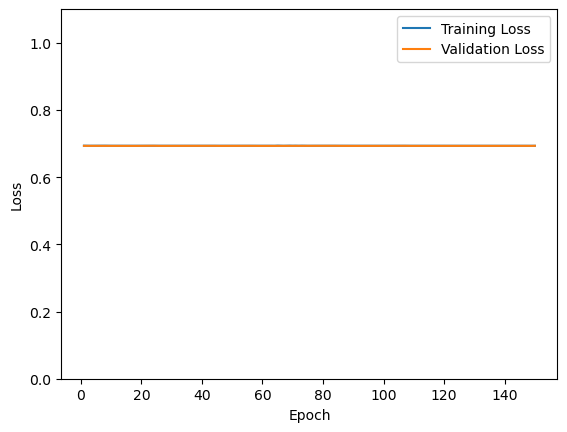

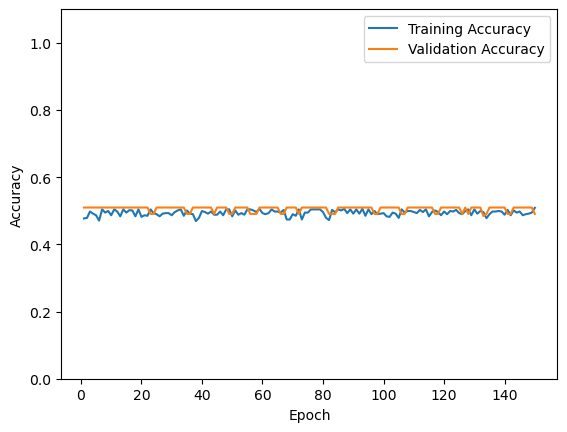

In [21]:
# Plot training and validation loss
plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,1.1])
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1.1])
plt.legend()
plt.show()

## Part 6. Improve the Model and Evaluate the Performance

In [22]:
loss, accuracy = nn_model.evaluate(X_test_tfidf.toarray(), y_test)
print('Loss: ', str(loss) , 'Accuracy: ', str(accuracy))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4977 - loss: 0.6932
Loss:  0.6931204795837402 Accuracy:  0.5037974715232849


### Prevent Overfitting and Improve Model's Performance

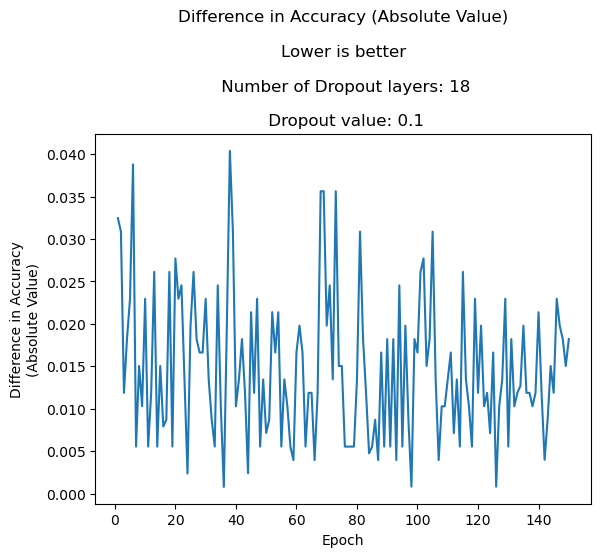

35     0.000777
97     0.000807
125    0.000807
23     0.002362
43     0.002392
86     0.003947
92     0.003947
58     0.003947
65     0.003947
106    0.003947
141    0.003977
83     0.004739
47     0.005532
62     0.005532
129    0.005532
75     0.005532
54     0.005532
18     0.005532
77     0.005532
78     0.005532
Name: accuracy_diff_abs, dtype: float64

In [23]:
# create a dict to store metrics that will become a dataframe
d = {'epoch_num':           range(1, num_epochs + 1),
     'accuracy_training':   history.history['accuracy'],
     'accuracy_validation': history.history['val_accuracy'],
     'loss_validation':     history.history['val_loss'],
     'loss_training':       history.history['loss']
    }

df_metrics_by_epoch = pd.DataFrame(data=d)

df_metrics_by_epoch['loss_diff']                = df_metrics_by_epoch['loss_validation']     - df_metrics_by_epoch['loss_training']
df_metrics_by_epoch['loss_diff_abs']            = df_metrics_by_epoch['loss_diff'].abs()
df_metrics_by_epoch['accuracy_diff']            = df_metrics_by_epoch['accuracy_validation'] - df_metrics_by_epoch['accuracy_training']
df_metrics_by_epoch['accuracy_diff_abs']        = df_metrics_by_epoch['accuracy_diff'].abs()
df_metrics_by_epoch['validation_split']         = validation_split
df_metrics_by_epoch['SGD_learning_rate']        = SGD_learning_rate
num_model_hidden_layers = len(nn_model.layers) - 2
num_dropout_layers = num_model_hidden_layers # num_model_hidden_layers - 3
df_metrics_by_epoch['num_model_hidden_layers']  = num_model_hidden_layers

plt.plot(range(1, num_epochs + 1), df_metrics_by_epoch['accuracy_diff_abs'], label='Accuracy Difference (Absolute Value)')
plt.xlabel('Epoch')
plt.ylabel('Difference in Accuracy\n(Absolute Value)')
plt.title(f'Difference in Accuracy (Absolute Value)\n\nLower is better\n\n Number of Dropout layers: {num_dropout_layers}\n\n Dropout value: {dropout_value}')
# plt.legend()
plt.show()

# show the epochs with the lowest (absolute) difference in accuracy:
df_metrics_by_epoch.sort_values('accuracy_diff_abs')['accuracy_diff_abs'].head(20)

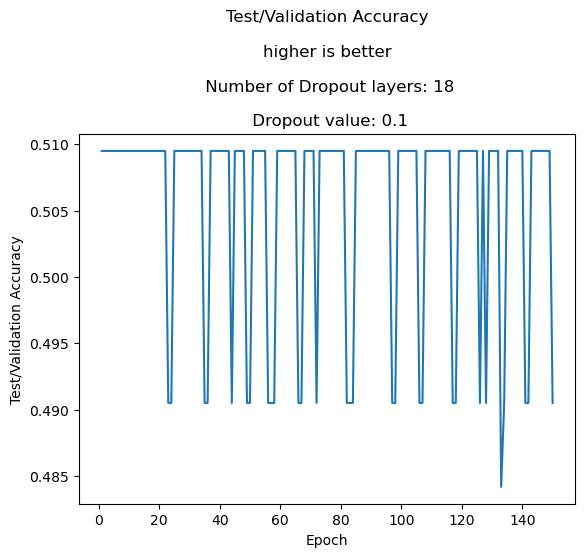

0      0.509494
88     0.509494
104    0.509494
103    0.509494
102    0.509494
101    0.509494
100    0.509494
99     0.509494
98     0.509494
95     0.509494
Name: accuracy_validation, dtype: float64

In [24]:
# Which value of num_epochs resulted in the best accuracy score when evaluating the test data?
plt.plot(range(1, num_epochs + 1), df_metrics_by_epoch['accuracy_validation'], label='Accuracy in validation')
plt.xlabel('Epoch')
plt.ylabel('Test/Validation Accuracy')
#plt.legend()
plt.title(f'Test/Validation Accuracy\n\nhigher is better\n\n Number of Dropout layers: {num_dropout_layers}\n\n Dropout value: {dropout_value}')
plt.show()

# show the epochs with the lowest (absolute) difference in accuracy:
df_metrics_by_epoch.sort_values('accuracy_validation', ascending=False)['accuracy_validation'].head(10)


In [25]:
t1 = time.time()

print(t1-t0)

391.3930010795593
